# Inventory Monitoring at Distribution Centers
Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. In this project, you will have to build a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items.

This project is built with AWS SageMaker and machine learning engineering techniques to fetch data from a public database, preprocess it, and then train a machine learning model. This project will serve as a demonstration of end-to-end machine learning engineering skills that you have learned as a part of this nanodegree.

In [1]:
# Installing required packages
!pip install smdebug torch torchvision tqdm

In [2]:
# Importing  packages 
import os
import shutil
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets.

In [11]:
import os
import json
import boto3
from tqdm import tqdm
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:35<00:00, 12.82it/s]


100%|██████████| 2299/2299 [03:10<00:00, 12.06it/s]


100%|██████████| 2666/2666 [03:56<00:00, 11.27it/s]


100%|██████████| 2373/2373 [03:23<00:00, 11.64it/s]


100%|██████████| 1875/1875 [02:40<00:00, 11.68it/s]


## splitting the dataset
The train_data folder is splitted into 3 parts. 10% into test/, 15% into val/, and 75% into train/.

In [ ]:
shutil.copytree('train_data', 'train_data_1')

In [ ]:
shutil.rmtree('copytrain_data')
#shutil.rmtree('train')
#shutil.rmtree('test')
#shutil.rmtree('train_data_1')

In [ ]:


data=os.listdir("train_data_1")

if not os.path.exists('train'):
    os.makedirs('train/1')
    os.makedirs('train/2')
    os.makedirs('train/3')
    os.makedirs('train/4')
    os.makedirs('train/5')
if not os.path.exists('test'):
    os.makedirs('test/1')
    os.makedirs('test/2')
    os.makedirs('test/3')
    os.makedirs('test/4')
    os.makedirs('test/5')
if not os.path.exists('val'):
    os.makedirs('val/1')
    os.makedirs('val/2')
    os.makedirs('val/3')
    os.makedirs('val/4')
    os.makedirs('val/5')
    
for d in data:
    l = os.listdir('train_data_1/'+d)
    print(len(l), '15% val', int(len(l)*.15), '10% test', int(len(l)*.1))
    val_split=int(len(l)*.15)
    test_split= int(len(l)*.1)
    
    for i in l[:val_split]:
        shutil.move('train_data_1/'+d+'/'+i, 'val/'+d+'/'+i)
        
    for i in l[-test_split:]:
        shutil.move('train_data_1/'+d+'/'+i, 'test/'+d+'/'+i)
    
#shutil.move('train_data_1/', 'train/')
        

        

## Dataset
****The dataset is Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [4]:
#data preprocessing
from glob import glob
item_classes = [item[15:16] for item in sorted(glob("./images/train/*/"))]


In [5]:
item_classes

[]

In [5]:
import glob
print('number of images in train dataset',len(glob.glob('./images/train/*/*')))
print('number of images in test dataset',len(glob.glob('./images/test/*/*')))
print('number of images in validation dataset',len(glob.glob('./images/val/*/*')))

number of images in train dataset 7837
number of images in test dataset 1041
number of images in validation dataset 1563


In [6]:
# Upload the data to AWS S3
sessio = sagemaker.Session()

bucket = sessio.default_bucket()
print("Default Bucket: {}".format(bucket))

region =sessio.boto_region_name
print("AWS region: {}".format(region))

role = get_execution_role()
print("Role : {}".format(role))

data_directory= 'udacityfinalproject'
print("dataset directory:", data_directory)

Default Bucket: sagemaker-us-east-1-119699166201
AWS region: us-east-1
Role : arn:aws:iam::119699166201:role/service-role/AmazonSageMaker-ExecutionRole-20220105T135857
dataset directory: udacityfinalproject


In [ ]:
!aws s3 cp images s3://udacityfinalproject/ --recursive

## Hyperparameter Tuning
we use a range of hyperparameters for tuning our pre-trained model. The model that we use is **ResNet50**.  
The `train.py` script contains the details of training the model.

In [7]:
#Declare model training hyperparameter.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([16, 32, 64]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
# training estimator
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_inventory_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [9]:
#  Fit estimator
os.environ['SM_CHANNEL_TRAINING']='s3://udacityfinalproject/'
os.environ['SM_MODEL_DIR']='s3://udacityfinalproject/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacityfinalproject/output/'
tuner.fit({"training": "s3://udacityfinalproject/"})

## Finding the best hyperparameters
The tuner above created 4 training jobs that are listed below with their FinalObjectValues. The best value (least test loss) will be selected for our model training.

In [10]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220123-0656')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""32""",0.001402,pytorch-training-220123-0656-002-2fd376a5,Completed,47.0,2022-01-23 06:59:03+00:00,2022-01-23 07:21:30+00:00,1347.0
0,"""16""",0.100000,pytorch-training-220123-0656-004-2cb9abd5,Completed,25.0,2022-01-23 07:28:26+00:00,2022-01-23 07:49:46+00:00,1280.0
1,"""16""",0.043910,pytorch-training-220123-0656-003-33295db6,Completed,25.0,2022-01-23 07:28:13+00:00,2022-01-23 07:50:49+00:00,1356.0
3,"""16""",0.003116,pytorch-training-220123-0656-001-df2cbc2b,Completed,23.0,2022-01-23 06:58:50+00:00,2022-01-23 07:21:14+00:00,1344.0


In [11]:
best_estimator=tuner.best_estimator()



2022-01-23 17:03:20 Starting - Preparing the instances for training
2022-01-23 17:03:20 Downloading - Downloading input data
2022-01-23 17:03:20 Training - Training image download completed. Training in progress.
2022-01-23 17:03:20 Uploading - Uploading generated training model
2022-01-23 17:03:20 Completed - Training job completed


In [12]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"16"',
 'learning_rate': '0.004194668812402398',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_inventory_hpo-2022-01-23-16-09-48-769"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-119699166201/pytorch_inventory_hpo-2022-01-23-16-09-48-769/source/sourcedir.tar.gz"'}

In [13]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 16, 'learning_rate': '0.004194668812402398'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model.
We use the `train.py` script to perform model profiling and debugging.

In [14]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [15]:
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

estimator = PyTorch(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge', 
    hyperparameters=hyperparameters,
    framework_version='1.4.0',
    py_version='py3',
    #env={"MMS_DEFAULT_RESPONSE_TIMEOUT": "6000"},
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

## Creating an Estimator
We run the pre-trained model **ResNet50** with the best hyperparameters.

In [16]:
estimator.fit({"training": "s3://udacityfinalproject/"})

2022-01-23 17:09:00 Starting - Starting the training job...
2022-01-23 17:09:26 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-23 17:10:26 Starting - Preparing the instances for training......
2022-01-23 17:11:27 Downloading - Downloading input data...............
2022-01-23 17:13:54 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-23 17:14:03,937 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-23 17:14:03,960 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-23 17:14:03,964 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-23 17:14:04,357 sagemaker-containers INFO     Module default_user_module_name do

## Plot a debugging output

In [17]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2022-01-23-17-09-00-135
Region: us-east-1
[2022-01-23 17:35:25.376 ip-172-16-117-236:2832 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-23 17:35:25.389 ip-172-16-117-236:2832 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/debug-output
[2022-01-23 17:35:25.903 ip-172-16-117-236:2832 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4682 more expected)', IncompleteRead(0 bytes read, 4682 more expected)) while reading s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/debug-output/index/000000000/000000000420_worker_0.json . Will retry now
[2022-01-23 17:35:28.982 ip-172-16-117-236:2832 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-23 17:35:30.006 ip-172-16-117-236:2832 INFO trial

In [18]:
tensor_name = "CrossEntropyLoss_output_0"

In [19]:
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    print(tensor)
    steps = tensor.steps(mode=mode)
    print(steps)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [20]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480]


([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480],
 [array(1.5480562, dtype=float32),
  array(1.8681304, dtype=float32),
  array(1.545499, dtype=float32),
  array(1.4847031, dtype=float32),
  array(1.5686996, dtype=float32),
  array(1.5889049, dtype=float32),
  array(1.5764306, dtype=float32),
  array(1.6088029, dtype=float32),
  array(1.6212295, dtype=float32),
  array(1.7308818, dtype=float32),
  array(1.6954268, dtype=float32),
  array(1.5667508, dtype=float32),
  array(1.5573362, dtype=float32),
  array(1.6085949, dtype=float32),
  array(1.5314014, dtype=float32),
  array(1.5830333, dtype=float32),
  array(1.8286097, dtype=float32),
  array(1.5146455, dtype=float32),
  array(1.436244, dtype=float32),
  ar

In [21]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480]
loaded TRAIN data
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163]
loaded EVAL data
completed TRAIN plo

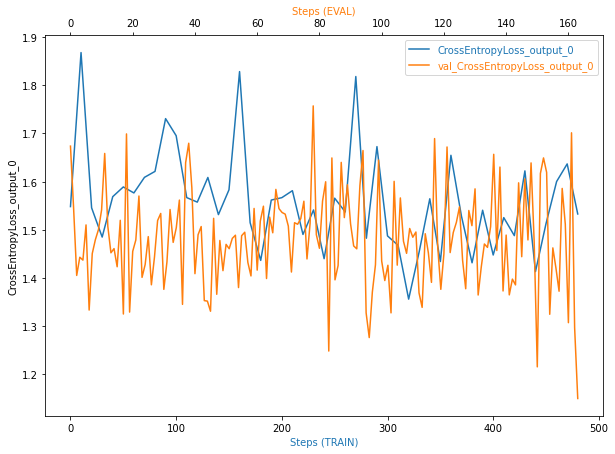

In [22]:
from smdebug.core.modes import ModeKeys
from matplotlib import pyplot as plt
    
# Plot the curve
plot_tensor(trial, 'CrossEntropyLoss_output_0')

Q: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
If not, suppose there was an error. What would that error look like and how would you have fixed it?

A: Although the plot shows the trend of having smaller loss, it shows fluctuations on crossentropyloss for both train and evaluation. One of the reasons behind this is the visibility of the images. The number of items in bins are usually difficult to be distinguished even with human eyes. Another reason might be the small size of the dataset that we are using for this project. By using model with more depth (layers), adding more hyperparameters, or tuning the hyperparameters we can achive to better result.

In [23]:
rule_output_path = estimator.output_path + estimator.latest_training_job.name + "/rule-output"
print(f"Profiler report path: {rule_output_path}")

Profiler report path: s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/rule-output


In [24]:
! aws s3 ls {rule_output_path} --recursive

2022-01-23 17:35:02     380218 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-23 17:35:01     230646 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-23 17:34:57        551 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-23 17:34:57     102496 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-23 17:34:57        126 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-23 17:34:57        130 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-23 17:34:57       3881 pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-re

In [25]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/rul

In [26]:
from IPython.display import FileLink, FileLinks

# Get the profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [27]:
report_file_name = profiler_report_name + "/profiler-output/profiler-report.html"
display("Profiler report link", FileLink(report_file_name))

'Profiler report link'

/home/ec2-user/SageMaker/nd009t-capstone-starter/starter/ProfilerReport/profiler-output/profiler-report.html

## Refinement /improvment of the model
To improve the model there are some options that could be applied, such as changing the architecture of the training algorithm, adding augmentation to the dataset during preprocessing, and adding/tuning hyperparameters. 


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [22]:
data_dir = 'data/train'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.RandomRotation(30),  # data augmentations 
                                       transforms.RandomResizedCrop((224,224)),  
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                       #                     [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['1', '2', '3', '4', '5']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [4]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 5),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 3.153.. Test loss: 1.627.. Test accuracy: 0.254
Epoch 1/1.. Train loss: 1.652.. Test loss: 1.571.. Test accuracy: 0.266
Epoch 1/1.. Train loss: 1.569.. Test loss: 1.574.. Test accuracy: 0.254
Epoch 1/1.. Train loss: 1.549.. Test loss: 1.579.. Test accuracy: 0.226
Epoch 1/1.. Train loss: 1.573.. Test loss: 1.560.. Test accuracy: 0.237
Epoch 1/1.. Train loss: 1.529.. Test loss: 1.570.. Test accuracy: 0.251
Epoch 1/1.. Train loss: 1.568.. Test loss: 1.561.. Test accuracy: 0.236
Epoch 1/1.. Train loss: 1.519.. Test loss: 1.527.. Test accuracy: 0.262
Epoch 1/1.. Train loss: 1.520.. Test loss: 1.563.. Test accuracy: 0.228
Epoch 1/1.. Train loss: 1.537.. Test loss: 1.527.. Test accuracy: 0.267
Epoch 1/1.. Train loss: 1.540.. Test loss: 1.522.. Test accuracy: 0.258
Epoch 1/1.. Train loss: 1.516.. Test loss: 1.539.. Test accuracy: 0.277
Epoch 1/1.. Train loss: 1.544.. Test loss: 1.532.. Test accuracy: 0.269


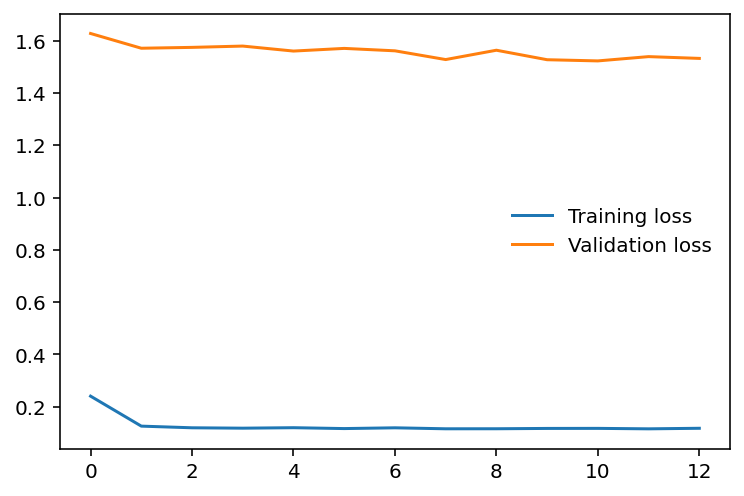

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [14]:
torch.save(model, 'refined_model.pth')

## Deployment (with refined model)

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [18]:
data_dir = './data/train'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [15]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model=torch.load('refined_model.pth')
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

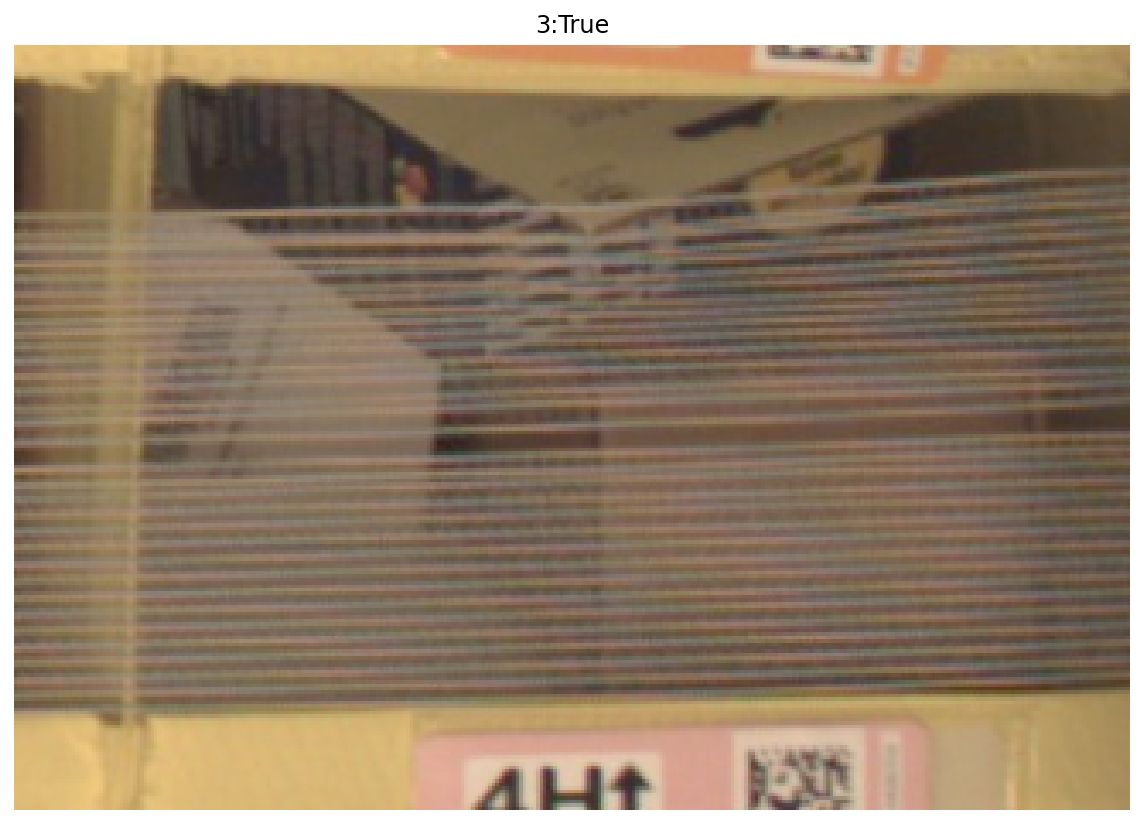

In [25]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(1)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(trainloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Deployment (without refinement)

In [7]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [29]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [30]:
model_location=estimator.model_data
model_location

's3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-09-00-135/output/model.tar.gz'

In [31]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [32]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [ ]:
!aws s3 cp s3://aft-vbi-pds/bin-images/03273.jpg 03273.jpg --no-sign-request

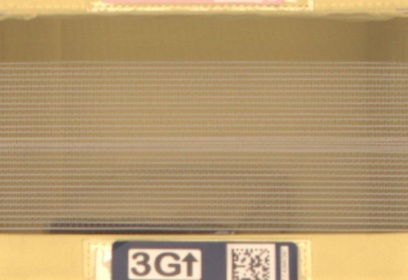

In [33]:
from PIL import Image
import io
def convert_pil_image_to_byte_array(img):
    img_byte_array = io.BytesIO()
    img.save(img_byte_array, format='JPEG', subsampling=0, quality=100)
    img_byte_array = img_byte_array.getvalue()
    return img_byte_array
img = Image.open(r'03273.jpg')
img.show()
img_byte = convert_pil_image_to_byte_array(img)

In [34]:
response=predictor.predict(img_byte, initial_args={"ContentType": "image/jpeg"})


In [35]:
import torch
import numpy as np
np.argmax(response, 1)

array([0])

In the pre-processing, we had `item_classes:['1', '2', '3', '4', '5']` as a list of classes. The response of `array[0]` is actually class '1'.
Now, we check what is the number of items in the bin from the metadata.

In [ ]:
!aws s3 cp s3://aft-vbi-pds/metadata/03273.json 03273.json --no-sign-request

In [36]:
import json
myjson= open('03273.json')
j = json.load(myjson)
print('EXPECTED_QUANTITY:' ,j['EXPECTED_QUANTITY'])

EXPECTED_QUANTITY: 1


Correct prediction.  
Let's try another image.

In [ ]:
!aws s3 cp s3://aft-vbi-pds/bin-images/00454.jpg 00454.jpg --no-sign-request

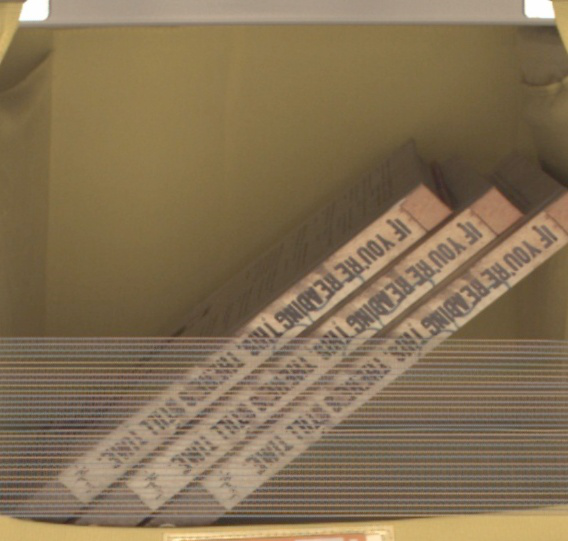

In [37]:
img2 = Image.open(r'00454.jpg')
img2.show()
img2_byte = convert_pil_image_to_byte_array(img2)

In [38]:
response2=predictor.predict(img2_byte, initial_args={"ContentType": "image/jpeg"})

In [39]:
np.argmax(response2, 1)


array([2])

Since the model has 5 classes: `item_classes:['1', '2', '3', '4', '5']` and index of the response array is 2, meaning that `items_classes[2]= 3` which is the number of detected items.

In [40]:
!aws s3 cp s3://aft-vbi-pds/metadata/00454.json 00454.json --no-sign-request
myjson= open('00454.json')
j = json.load(myjson)
print('EXPECTED_QUANTITY:' ,j['EXPECTED_QUANTITY'])

download: s3://aft-vbi-pds/metadata/00454.json to ./00454.json    
EXPECTED_QUANTITY: 3


## Benchmarking with ResNet18

Since our dataset is smaller and the accuracy turned out to be lower than expected. We can compare our approach with a simple ResNet18 model. 


In [41]:
estimator_2 = PyTorch(
    entry_point='train-18.py',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge', 
    hyperparameters={'batch_size': 16, 'learning_rate': '0.01'},
    framework_version='1.4.0',
    py_version='py3',
    #env={"MMS_DEFAULT_RESPONSE_TIMEOUT": "6000"},
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [42]:
estimator_2.fit({"training": "s3://udacityfinalproject/"})

2022-01-23 17:43:18 Starting - Starting the training job...
2022-01-23 17:43:47 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-23 17:44:47 Starting - Preparing the instances for training.........
2022-01-23 17:46:08 Downloading - Downloading input data.........
2022-01-23 17:47:48 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-23 17:47:57,665 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-23 17:47:57,694 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-23 17:48:03,961 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-23 17:48:04,279 sagemaker-containers INFO     Module default_user_module_name does

Now we get the best hyperparameter for this tuner and run the model once again only with the selected hpo. 

In [43]:
training_job_name = estimator_2.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator_2.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2022-01-23-17-43-18-439
Region: us-east-1
[2022-01-23 17:55:45.944 ip-172-16-117-236:2832 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-43-18-439/debug-output
[2022-01-23 17:55:46.250 ip-172-16-117-236:2832 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 1799 more expected)', IncompleteRead(0 bytes read, 1799 more expected)) while reading s3://sagemaker-us-east-1-119699166201/pytorch-training-2022-01-23-17-43-18-439/debug-output/index/000000000/000000000280_worker_0.json . Will retry now
[2022-01-23 17:55:48.377 ip-172-16-117-236:2832 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-23 17:55:49.416 ip-172-16-117-236:2832 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc

In [44]:
tensor_name_2 = "CrossEntropyLoss_output_0"


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480]
loaded TRAIN data
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 1

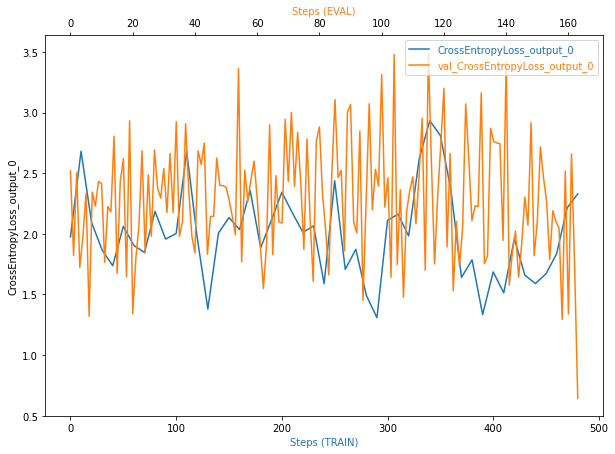

In [45]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
plot_tensor(trial, 'CrossEntropyLoss_output_0')


## Model Evaluation

The table below shows the Testing Accuracy and Testing loss from two models that we trained in this project.

In [46]:
from tabulate import tabulate

print(tabulate([['ResNet18', 36.0, 3.0], ['ResNet50', 23.0, 4.0]], headers=['Model', 'Testing Loss', 'Testing Accuracy']))


Model       Testing Loss    Testing Accuracy
--------  --------------  ------------------
ResNet18              36                   3
ResNet50              23                   4


## Benchmark with refined model

In [26]:
model_2= models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model_2.fc = nn.Sequential(nn.Linear(512, 5),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_2.fc.parameters(), lr=0.003)
model_2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model_2.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model_2.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model_2.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model_2.train()

Epoch 1/1.. Train loss: 1.735.. Test loss: 1.640.. Test accuracy: 0.225
Epoch 1/1.. Train loss: 1.615.. Test loss: 1.710.. Test accuracy: 0.231
Epoch 1/1.. Train loss: 1.613.. Test loss: 1.617.. Test accuracy: 0.253
Epoch 1/1.. Train loss: 1.583.. Test loss: 1.637.. Test accuracy: 0.253
Epoch 1/1.. Train loss: 1.605.. Test loss: 1.534.. Test accuracy: 0.272
Epoch 1/1.. Train loss: 1.594.. Test loss: 1.551.. Test accuracy: 0.282
Epoch 1/1.. Train loss: 1.613.. Test loss: 1.571.. Test accuracy: 0.267
Epoch 1/1.. Train loss: 1.547.. Test loss: 1.537.. Test accuracy: 0.267
Epoch 1/1.. Train loss: 1.582.. Test loss: 1.621.. Test accuracy: 0.250
Epoch 1/1.. Train loss: 1.574.. Test loss: 1.525.. Test accuracy: 0.277
Epoch 1/1.. Train loss: 1.552.. Test loss: 1.527.. Test accuracy: 0.275
Epoch 1/1.. Train loss: 1.569.. Test loss: 1.533.. Test accuracy: 0.284
Epoch 1/1.. Train loss: 1.586.. Test loss: 1.520.. Test accuracy: 0.289


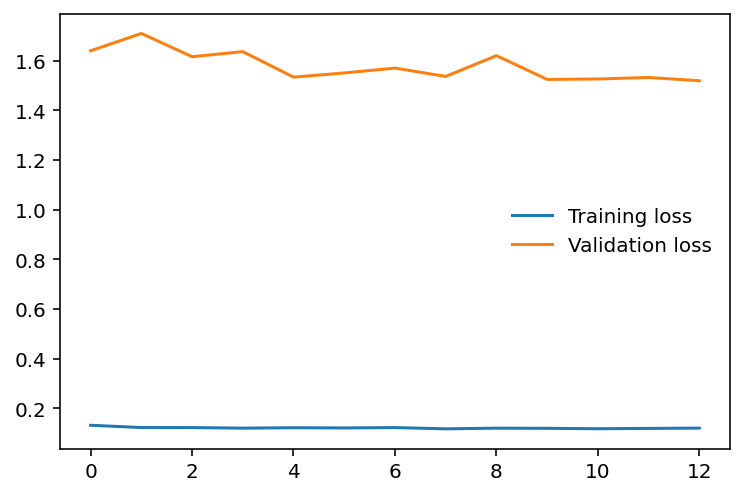

In [37]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Justification


The model could benefit from furthur refinements. The comparison between the models' Testing Accuracy, we can see that the model with deeper layers has better accuracy in predicting images. Nevertheless, the current model accuracy is sufficient for our purpose. 